In [1]:
import torch
from torch import nn
import numpy as np
import gym 
import matplotlib.pyplot as plt
import tqdm
import time
import glob
import json
import os

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
torch.__version__

'1.5.0'

In [220]:
l = 10
ll =len([0,1,2,3])

In [222]:
list(range(ll, l))

[4, 5, 6, 7, 8, 9]

In [82]:
class CrossEntropyMethod(nn.Module):
    def __init__(self, name, state_dim, action_n, layers_n, lr=0.01):
        super().__init__()
        self.name = name
        self.state_dim = state_dim
        self.action_n = action_n
        self.lr = lr
        if len(layers_n)==1:
            self.network = nn.Sequential(
                nn.Linear(self.state_dim, layers_n[0]),
                nn.ReLU(),
                nn.Linear(layers_n[0], self.action_n)
            )
        if len(layers_n)==2:
            self.network = nn.Sequential(
                nn.Linear(self.state_dim, layers_n[0]),
                nn.ReLU(),
                nn.Linear(layers_n[0], layers_n[1]),
                nn.ReLU(),
                nn.Linear(layers_n[1], self.action_n)
            )
        if len(layers_n)==3:
            self.network = nn.Sequential(
                nn.Linear(self.state_dim, layers_n[0]),
                nn.ReLU(),
                nn.Linear(layers_n[0], layers_n[1]),
                nn.ReLU(),
                nn.Linear(layers_n[1], layers_n[2]),
                nn.ReLU(),
                nn.Linear(layers_n[2], self.action_n)
            )

        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.loss = nn.CrossEntropyLoss()
#         self.to(device)
#         self.policy = np.ones((self.state_n, self.action_n)) / self.action_n
    
    def forward(self, _input):
        return self.network(_input)
    
    def get_action(self, state):
        state = torch.FloatTensor(state)# .to(device)
        logits = self.network(state)
        # action_prob = self.softmax(logits).cpu().detach().numpy()
        action_prob = self.softmax(logits).detach().numpy()
        action = np.random.choice(self.action_n, p=action_prob)
        return action

    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        assert len(elite_states)==len(elite_actions), f'{len(elite_states)},{len(elite_actions)}'

        elite_states = torch.FloatTensor(elite_states)#.to(device)
        elite_actions = torch.LongTensor(elite_actions)#.to(device)
        loss = self.loss(self.forward(elite_states), elite_actions)
        # calculating gradients
        loss.backward()
        # update the weights
        self.optimizer.step()
        # zero grad
        self.optimizer.zero_grad()
        self.save_policy()
    def get_name(self):
        return os.path.join(EXP_DIR, self.name+'.nn')
    def save_policy(self):
        torch.save(self.state_dict(), self.get_name())

    def load_policy(self):
        if os.path.exists(self.get_name()):
            self.load_state_dict(torch.load(self.get_name()))

In [ ]:
def get_trajectory(env, agent, trajectory_len, visualize=False):
    trajectory = {
        'states':[], 
        'actions':[],
        'total_reward': 0}
    state = env.reset()
#     trajectory['states'].append(state)
    for _ in range(trajectory_len):
        action = agent.get_action(state)
        trajectory['states'].append(state)
        trajectory['actions'].append(action)
        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward
        if done:
            break
        
        if visualize:
            env.render()

    assert len(trajectory['actions'])==len(trajectory['states']), f"gt {len(trajectory['actions'])},{len(trajectory['states'])}"
    return trajectory

In [54]:
def get_trajectory(env, agent, trajectory_len, visualize=False):
    trajectory = {
        'states':[], 
        'actions':[],
        'total_reward': 0}
    state = env.reset()
#     trajectory['states'].append(state)
    for _ in range(trajectory_len):
        action = agent.get_action(state)
        trajectory['states'].append(state)
        trajectory['actions'].append(action)
        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward
        if done:
            break
        
        if visualize:
            env.render()

    assert len(trajectory['actions'])==len(trajectory['states']), f"gt {len(trajectory['actions'])},{len(trajectory['states'])}"
    return trajectory

In [55]:
def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param) 
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

In [223]:
# env = gym.make('CartPole-v1')
env = gym.make('LunarLander-v2')

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [225]:
env.reset()

array([-0.00412664,  1.4057952 , -0.41801175, -0.22778343,  0.00478864,
        0.09468576,  0.        ,  0.        ], dtype=float32)

In [226]:
img = env.render(mode='rgb_array')

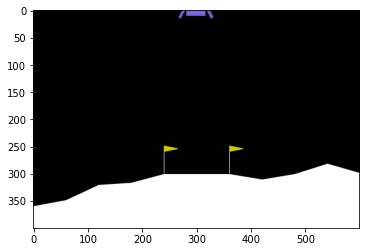

In [228]:
plt.imshow(img)

In [227]:
imga

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [57]:
state_dim = 8
action_n = 4

agent = CrossEntropyMethod('test', state_dim, action_n, layer_n1=100)
episode_n = 10
trajectory_n = 40
trajectory_len = 500
q_param = 0.8



In [58]:
mean_total_rewards = []

In [205]:
from queue import Queue
import threading


In [211]:
import datetime

In [215]:
datetime.datetime.now(), 

(datetime.datetime(2022, 11, 22, 20, 1, 43, 336861),
 datetime.datetime(2022, 11, 22, 20, 1, 33, 336864))

In [203]:
q=Queue()

In [204]:
q.put(get_trajectory(env, agent, 10))

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
os.makedirs()

In [209]:
q.get()

KeyboardInterrupt: 

In [210]:
import time
import threading
from queue import Queue
import numpy as np

In [ ]:
def get_trajectory_mt(task_queue, output_queue, env, agent, trajectory_len):
    while True:
        if task_queue.empty(): break
        _ = task_queue.get()
        
        trajectory = get_trajectory(env, agent, trajectory_len, visualize=False)
        output_queue.put(trajectory)
        
        task_queue.task_done()

def get_trajectories_mt(env, agent, trajectory_n,t rajectory_len, threads):
    
    task_queue = Queue()
    output_queue = Queue()
    for i in range(trajectory_n)
        task_queue.put(i)

    for index in range(num_worker_threads):
        thread = threading.Thread(target=get_trajectory_mt, args=(task_queue, output_queue, env, agent, trajectory_len))
        thread.start()
        thread.join()

        outputQ.put()
            outputQ
    ret = [q.get() for q in output_queue]

In [59]:
for _ in tqdm.tqdm_notebook(range(episode_n)):
    trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    mean_total_rewards.append(mean_total_reward)
    print(mean_total_reward)
    
    elite_trajectories = get_elite_trajectories(trajectories, q_param)
    
    if len(elite_trajectories)>0:
        agent.update_policy(elite_trajectories)

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-174.3044616594158
-200.51771481427826
-214.60137719501896
-156.8390113802936
-167.21130480895204
-134.51633116260095
-152.56419807918547
-122.66981892874912
-145.27520837277848



KeyboardInterrupt: 

In [39]:
torch.save(agent.state_dict(), 'test')

In [101]:
def replay(eid, episodes = 100):
    ed = json.load(open(os.path.join(EXP_DIR, eid+".json")))

    layers_n = ed['layers_n']
    episode_n = ed['episode_n']
    trajectory_len = ed['trajectory_len']
    trajectory_n = ed['trajectory_n']
    q_param = ed['q_param']
    total_elapsed = ed['total_elapsed']
    print(f'layers_n={layers_n} \nepisode_n={episode_n}\ntrajectory_len={trajectory_len} \ntrajectory_n={trajectory_n} \nq_param={q_param} \ntotal_elapsed={total_elapsed}')
    agent = CrossEntropyMethod(eid, state_dim, action_n, layers_n=layers_n)
    agent.load_policy()
    tjs = []
    while True:
        t = get_trajectory(env, agent, trajectory_len, visualize=True)
        tjs.append(t['total_reward'])

In [103]:
def get_stats(eid, episodes):
    ed = json.load(open(os.path.join(EXP_DIR, eid+".json")))

    layers_n = ed['layers_n']
    episode_n = ed['episode_n']
    trajectory_len = ed['trajectory_len']
    trajectory_n = ed['trajectory_n']
    q_param = ed['q_param']
    total_elapsed = ed['total_elapsed']
    print(f'layers_n={layers_n} \nepisode_n={episode_n}\ntrajectory_len={trajectory_len} \ntrajectory_n={trajectory_n} \nq_param={q_param} \ntotal_elapsed={total_elapsed}')
    agent = CrossEntropyMethod(eid, state_dim, action_n, layers_n=layers_n)
    agent.load_policy()
    tjs = []
    for _ in tqdm.tqdm(range(episodes)):
        t = get_trajectory(env, agent, trajectory_len, visualize=False)
        tjs.append(t['total_reward'])
    return tjs

In [102]:
replay(eid = '6405310643')

layer_n1=100 
episode_n=200
trajectory_len=1000 
trajectory_n=70 
q_param=0.8 
total_elapsed=6484.341369


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


KeyboardInterrupt: 

In [105]:
get_stats('6405310643', 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

layer_n1=100 
episode_n=200
trajectory_len=1000 
trajectory_n=70 
q_param=0.8 
total_elapsed=6484.341369


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


[290.92685005787155,
 235.7335628801832,
 269.09268472190445,
 232.52486479591977,
 296.37371441847745,
 275.2420096930936,
 276.43191268988573,
 264.34936945266213,
 282.12878198301877,
 290.6140646758097,
 265.6060940288946,
 225.68836820513337,
 228.18779816704446,
 269.2717809719889,
 317.83794622428707,
 237.61796909386806,
 247.10662577976146,
 208.42478589784258,
 283.88888712611976,
 271.2447871741547,
 246.81766986386071,
 263.0409976644147,
 302.68122653162175,
 278.4202761300093,
 249.91224714442768,
 250.75839761166893,
 281.2302236827262,
 212.223943190181,
 281.2649221936535,
 258.40987672926065,
 292.8634048321537,
 278.303091917546,
 244.17377983951903,
 156.39181287642737,
 274.5501157861712,
 268.9877607736461,
 296.8192782156468,
 259.541755064335,
 142.67658433098524,
 251.17703347290677,
 256.41163881511363,
 292.7604739678959,
 249.65613777003244,
 226.25365141040038,
 248.66795537592748,
 245.7212575184899,
 302.9085058939605,
 294.88166191241316,
 299.5230649310

In [89]:
agent = CrossEntropyMethod('6405310643', state_dim, action_n, layers_n=[200])


In [91]:
trajectory_len

500

In [90]:
tjs = []
while True:
    t = get_trajectory(env, agent, trajectory_len, visualize=True)
    tjs.append(t['total_reward'])

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

In [86]:
agent.load_policy()

In [41]:
agent.load_state_dict(torch.load('test'))


<All keys matched successfully>

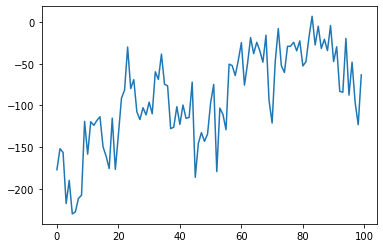

In [12]:
plt.plot(range(len(mean_total_rewards)), mean_total_rewards)
plt.show()

In [35]:
tjs = get_trajectory(env, agent, trajectory_len, visualize=True)
print(tjs['total_reward'])

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


-356.68513848830753


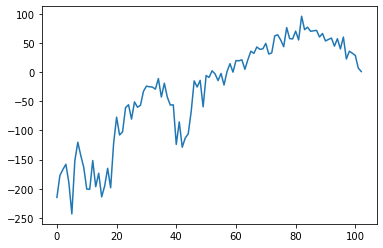

In [18]:
plt.plot(range(len(mean_total_rewards)), mean_total_rewards)
plt.show()

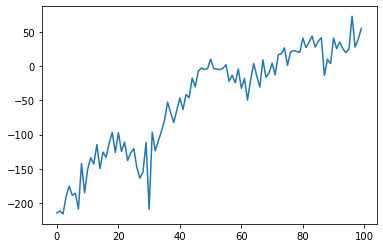

In [9]:
plt.plot(range(len(mean_total_rewards)), mean_total_rewards)
plt.show()

In [14]:
TASKS_DIR = './tasks/'
EXP_DIR = './experiments/'
for d in [TASKS_DIR, EXP_DIR]:
    os.makedirs(d, exist_ok=True)

In [9]:
def nest_permutate(seq, vals, opts):
    
    for i in opts[0]:
        if len(opts)==1:
            seq.append(vals+[i])
        else:
            nest_permutate(seq, vals+[i], opts[1:])

In [152]:
# проверяем влияние кол-ва нейронов
layers_n = [[10], [30], [65], [100], [200], [400]]
episodes_n = [400]
trajectories_n = [50, 200, 400]
trajectories_len = [500]
q_params = [0.5]
versions=['2']

In [169]:
layers_n = [[10,10], [30], [65], [100], [150], [200]]
episodes_n = [200]
trajectories_n = [10, 50, 150, 300]
trajectories_len = [500, 1000]
q_params = [0.5, 0.7, 0.8, 0.9]
versions=['1']

In [170]:
tasks = []
combins = [layers_n, versions, episodes_n,trajectories_n, trajectories_len, q_params]
nest_permutate(tasks, [], combins)
len(tasks)

192

In [171]:
tasks

[[[10, 10], '1', 200, 10, 500, 0.5],
 [[10, 10], '1', 200, 10, 500, 0.7],
 [[10, 10], '1', 200, 10, 500, 0.8],
 [[10, 10], '1', 200, 10, 500, 0.9],
 [[10, 10], '1', 200, 10, 1000, 0.5],
 [[10, 10], '1', 200, 10, 1000, 0.7],
 [[10, 10], '1', 200, 10, 1000, 0.8],
 [[10, 10], '1', 200, 10, 1000, 0.9],
 [[10, 10], '1', 200, 50, 500, 0.5],
 [[10, 10], '1', 200, 50, 500, 0.7],
 [[10, 10], '1', 200, 50, 500, 0.8],
 [[10, 10], '1', 200, 50, 500, 0.9],
 [[10, 10], '1', 200, 50, 1000, 0.5],
 [[10, 10], '1', 200, 50, 1000, 0.7],
 [[10, 10], '1', 200, 50, 1000, 0.8],
 [[10, 10], '1', 200, 50, 1000, 0.9],
 [[10, 10], '1', 200, 150, 500, 0.5],
 [[10, 10], '1', 200, 150, 500, 0.7],
 [[10, 10], '1', 200, 150, 500, 0.8],
 [[10, 10], '1', 200, 150, 500, 0.9],
 [[10, 10], '1', 200, 150, 1000, 0.5],
 [[10, 10], '1', 200, 150, 1000, 0.7],
 [[10, 10], '1', 200, 150, 1000, 0.8],
 [[10, 10], '1', 200, 150, 1000, 0.9],
 [[10, 10], '1', 200, 300, 500, 0.5],
 [[10, 10], '1', 200, 300, 500, 0.7],
 [[10, 10], '1',

In [190]:
def generate_tasks(layers_n, version, episode_n, trajectory_n, trajectory_len, q_param):
    os.makedirs(TASKS_DIR, exist_ok=True)
    files = list(glob.glob(os.path.join(TASKS_DIR, '*.json')))
    
    exp_set = set()
    for file in files:
        ed = json.load(open(file, 'r'))
        exp_id = '_'.join([str(ed['version']), str(ed['layers_n']),str( ed['episode_n']), str(ed['trajectory_len']), str(ed['trajectory_n']), str(ed['q_param'])])
        exp_set.add(exp_id)
    
#     print(exp_set)
    exp_id = '_'.join(         [version,      str(layers_n), str(episode_n), str(trajectory_len), str(trajectory_n), str(q_param)])
    if exp_id in exp_set: 
        print('Allready created', exp_id)
        return 0
    exp = {
            'id': str(time.process_time_ns()),
            'version':version,
            'layers_n': layers_n,
            'episode_n':episode_n,
            'trajectory_len':trajectory_len,
            'trajectory_n':trajectory_n,
            'q_param':q_param
    }
    f = open(os.path.join(TASKS_DIR,f'{exp["id"]}.json'), 'w')
    json.dump(exp, f)
    return 1

In [192]:
# изучаем работу слоев
# v3
# 1 ДОбавить 1 промежуточный слой
# 1-1 придумать разные конфигурации слоев


# проверяем влияние кол-ва нейронов
layer_n1 = [10, 30, 65, 100, 200, 400]
layer_n2 = [10, 30, 65, 100, 200, 400]
layers =[]
combins = [layer_n1, layer_n2]
nest_permutate(layers, [], combins)

episodes_n = [400]
trajectories_n = [100]
trajectories_len = [500]
q_params = [0.5]
tasks = []
versions=['3']
combins = [layers, versions, episodes_n,trajectories_n, trajectories_len, q_params]
nest_permutate(tasks, [], combins)
for task in tasks:
    generate_tasks(*task)


Allready created 3_[10, 10]_400_500_100_0.5
Allready created 3_[10, 30]_400_500_100_0.5
Allready created 3_[10, 65]_400_500_100_0.5
Allready created 3_[10, 100]_400_500_100_0.5
Allready created 3_[10, 200]_400_500_100_0.5
Allready created 3_[10, 400]_400_500_100_0.5
Allready created 3_[30, 10]_400_500_100_0.5
Allready created 3_[30, 30]_400_500_100_0.5
Allready created 3_[30, 65]_400_500_100_0.5
Allready created 3_[30, 100]_400_500_100_0.5
Allready created 3_[30, 200]_400_500_100_0.5
Allready created 3_[30, 400]_400_500_100_0.5
Allready created 3_[65, 10]_400_500_100_0.5
Allready created 3_[65, 30]_400_500_100_0.5
Allready created 3_[65, 65]_400_500_100_0.5
Allready created 3_[65, 100]_400_500_100_0.5
Allready created 3_[65, 200]_400_500_100_0.5
Allready created 3_[65, 400]_400_500_100_0.5
Allready created 3_[100, 10]_400_500_100_0.5
Allready created 3_[100, 30]_400_500_100_0.5
Allready created 3_[100, 65]_400_500_100_0.5
Allready created 3_[100, 100]_400_500_100_0.5
Allready created 3

In [195]:
# v4
# 2 ДОбавить 2 промежуточный слой
# 2-1 придумать разные конфигурации слоев

layer_n1 = [10, 30, 65, 100, 200, 400]
layer_n2 = [10, 30, 65, 100, 200, 400]
layer_n3 = [10, 30, 65, 100, 200, 400]
layers =[]
combins = [layer_n1, layer_n2, layer_n3]
nest_permutate(layers, [], combins)

episodes_n = [400]
trajectories_n = [100]
trajectories_len = [500]
q_params = [0.5]
tasks = []
versions=['4']
combins = [layers, versions, episodes_n,trajectories_n, trajectories_len, q_params]
nest_permutate(tasks, [], combins)
for task in tasks:
    generate_tasks(*task)

In [194]:
tasks

[[[10, 10, 10], '4', 400, 100, 500, 0.5],
 [[10, 10, 30], '4', 400, 100, 500, 0.5],
 [[10, 10, 65], '4', 400, 100, 500, 0.5],
 [[10, 10, 100], '4', 400, 100, 500, 0.5],
 [[10, 10, 200], '4', 400, 100, 500, 0.5],
 [[10, 10, 400], '4', 400, 100, 500, 0.5],
 [[10, 30, 10], '4', 400, 100, 500, 0.5],
 [[10, 30, 30], '4', 400, 100, 500, 0.5],
 [[10, 30, 65], '4', 400, 100, 500, 0.5],
 [[10, 30, 100], '4', 400, 100, 500, 0.5],
 [[10, 30, 200], '4', 400, 100, 500, 0.5],
 [[10, 30, 400], '4', 400, 100, 500, 0.5],
 [[10, 65, 10], '4', 400, 100, 500, 0.5],
 [[10, 65, 30], '4', 400, 100, 500, 0.5],
 [[10, 65, 65], '4', 400, 100, 500, 0.5],
 [[10, 65, 100], '4', 400, 100, 500, 0.5],
 [[10, 65, 200], '4', 400, 100, 500, 0.5],
 [[10, 65, 400], '4', 400, 100, 500, 0.5],
 [[10, 100, 10], '4', 400, 100, 500, 0.5],
 [[10, 100, 30], '4', 400, 100, 500, 0.5],
 [[10, 100, 65], '4', 400, 100, 500, 0.5],
 [[10, 100, 100], '4', 400, 100, 500, 0.5],
 [[10, 100, 200], '4', 400, 100, 500, 0.5],
 [[10, 100, 400], 

In [66]:
import datetime

In [69]:
start = datetime.datetime.now()

In [70]:
end = datetime.datetime.now()

In [72]:
(end - start).total_seconds()

24.043762

In [63]:
def run_experiment(eid, versions, layers_n, episode_n, trajectory_len, trajectory_n, q_param):
    state_dim = 8
    action_n = 4

    agent = CrossEntropyMethod(eid, state_dim, action_n, layer_n1)

    exp = {
        'id': eid,
        'version':versions,
        'layers_n': layers_n,
        'episode_n':episode_n,
        'trajectory_len':trajectory_len,
        'trajectory_n':trajectory_n,
        'q_param':q_param,
        'finished':false,
        'total_elapsed':0,
        'episode_data':[]
    }
    started =  datetime.datetime.now()
    episode_data_path = os.path.join(EXP_DIR, f'{eid}.json')
    mean_total_rewards = []
    episode_data = []
    json.dump(exp, open(episode_data_path,'w'))

    # env = gym.make('CartPole-v1')
    env = gym.make('LunarLander-v2')
    for _ in tqdm.tqdm_notebook(range(episode_n)):
        trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]

        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
        mean_total_rewards.append(mean_total_reward)
        
        elite_trajectories = get_elite_trajectories(trajectories, q_param)
        episode_data.append((mean_total_reward, len(elite_trajectories)))

        if len(elite_trajectories)>0:
            agent.update_policy(elite_trajectories)
        exp['episode_data'] = episode_data
        exp['total_elapsed'] = (end - start).total_seconds()
        json.dump(exp, open(episode_data_path,'w'))
    exp['episode_data'] = episode_data
    exp['finished'] = true
    exp['total_elapsed'] = (end - start).total_seconds()
    json.dump(exp, open(episode_data_path,'w'))

In [64]:
def executor(tasks_dir, experiments_dir):
    tasks = list(glob.glob(os.path.join(tasks_dir, '*.json')))
    for task in tasks:
        task = json.load(open(task, 'r'))
        eid = task['id']
        try:
            f = open(os.path.join(experiments_dir, eid+'.json'),'x')
            f.close()
            versions = task['version']
            layers_n = task['layers_n']
            episode_n = task['episode_n']
            trajectory_len = task['trajectory_len']
            trajectory_n = task['trajectory_n']
            q_param = task['q_param']
            
            run_experiment(eid, versions, layer_n1, episode_n, trajectory_len, trajectory_n, q_param)

        except FileExistsError as err:
            pass

In [ ]:
executor(TASKS_DIR, EXP_DIR)

In [ ]:
tjs = get_trajectory(env, agent, trajectory_len, visualize=True)
print(tjs['total_reward'])

In [36]:
tjs = []
while True:
    t = get_trajectory(env, agent, trajectory_len, visualize=True)
    tjs.append(t['total_reward'])

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

In [61]:
tjs = get_trajectory(env, agent, trajectory_len, visualize=True)
print(tjs['total_reward'])

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


265.0038634828537


In [51]:
tjs = []
for _ in range(100):
    t = get_trajectory(env, agent, trajectory_len, visualize=False)
    tjs.append(t['total_reward'])

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
